In [3]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt

# Load FITS data
fits_path = '/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.fits'
hdu = fits.open(fits_path)[0]
data = hdu.data
img_shape = (hdu.header['NAXIS2'], hdu.header['NAXIS1'])  # (3617, 3617)

# Patch parameters
patch_size = 1024
overlap = int(0.2 * patch_size)  # Increased to 20% overlap for better context
step_size = patch_size - overlap
output_dir = '/users/vutomi/Source_Detection/YOLOs/Data/images/abell_209_patches'
label_dir = '/users/vutomi/Source_Detection/YOLOs/Data/labels/patches_improved'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

# Read original labels
label_path = '/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.txt'
with open(label_path, 'r') as f:
    lines = [line.strip().split() for line in f.readlines()]

# Generate patches and adjust labels
for i in range(0, img_shape[1] - patch_size + 1, step_size):
    for j in range(0, img_shape[0] - patch_size + 1, step_size):
        patch = data[j:j+patch_size, i:i+patch_size]
        # Normalize to preserve dynamic range (min-max scaling)
        patch_normalized = (patch - np.min(patch)) / (np.max(patch) - np.min(patch) + 1e-10)  # Avoid division by zero
        patch_filename = f'Abell_209_patch_{i//step_size}_{j//step_size}.png'
        plt.imsave(os.path.join(output_dir, patch_filename), patch_normalized, cmap='gray', origin='lower', vmin=0, vmax=1)

        # Adjust labels for this patch
        patch_labels = []
        for line in lines:
            class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line)
            x_center = x_center_norm * img_shape[1]
            y_center = (1 - y_center_norm) * img_shape[0]  # Reverse YOLO flip

            # Check if center is within patch
            if i <= x_center < i + patch_size and j <= y_center < j + patch_size:
                # Convert to patch coordinates
                x_patch = (x_center - i) / patch_size
                y_patch = (y_center - j) / patch_size
                width_patch = width_norm * (img_shape[1] / patch_size)
                height_patch = height_norm * (img_shape[0] / patch_size)
                if 0 <= x_patch <= 1 and 0 <= y_patch <= 1 and width_patch > 0 and height_patch > 0:
                    patch_labels.append(f"0 {x_patch:.6f} {y_patch:.6f} {width_patch:.6f} {height_patch:.6f}")

        if patch_labels:
            with open(os.path.join(label_dir, f'Abell_209_patch_{i//step_size}_{j//step_size}.txt'), 'w') as f:
                f.write('\n'.join(patch_labels))

print(f"Generated {len(os.listdir(output_dir))} patches and corresponding labels.")

Generated 16 patches and corresponding labels.


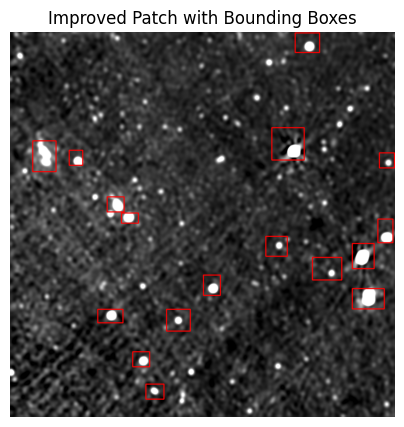

In [2]:
import cv2
import matplotlib.pyplot as plt

patch_path = '/users/vutomi/Source_Detection/YOLOs/Data/images/patches_improved/Abell_209_patch_0_0.png'
label_path = '/users/vutomi/Source_Detection/YOLOs/Data/labels/patches_improved/Abell_209_patch_0_0.txt'

img = cv2.imread(patch_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

with open(label_path, 'r') as f:
    for line in f.readlines():
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line.strip().split())
        x_center = int(x_center_norm * w)
        y_center = int((1 - y_center_norm) * h)
        width = int(width_norm * w)
        height = int(height_norm * h)
        x_min = int(x_center - width / 2)
        x_max = int(x_center + width / 2)
        y_min = int(y_center - height / 2)
        y_max = int(y_center + height / 2)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Improved Patch with Bounding Boxes')
plt.show()